# Analisis SHAP

In [1]:
%%capture
!pip install shap

In [2]:
import pandas as pd
import mlflow
import os
import shap
from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [3]:
engine = create_engine('mysql+mysqlconnector://ab:ab@mysql/Base_de_Datos')
df = pd.read_sql('SELECT * FROM clean_data_price', engine)

In [4]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://minio:9000"
os.environ['AWS_ACCESS_KEY_ID'] = 'minioadmin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minioadmin'
mlflow.set_tracking_uri("http://mlflow:8083")

In [5]:
model_name = "best_model"
model_prod_uri = "models:/{model_name}/production".format(model_name=model_name)
loaded_model = mlflow.sklearn.load_model(model_uri=model_prod_uri)

/usr/local/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [6]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

 95%|=================== | 39943/42084 [00:19<00:01]       

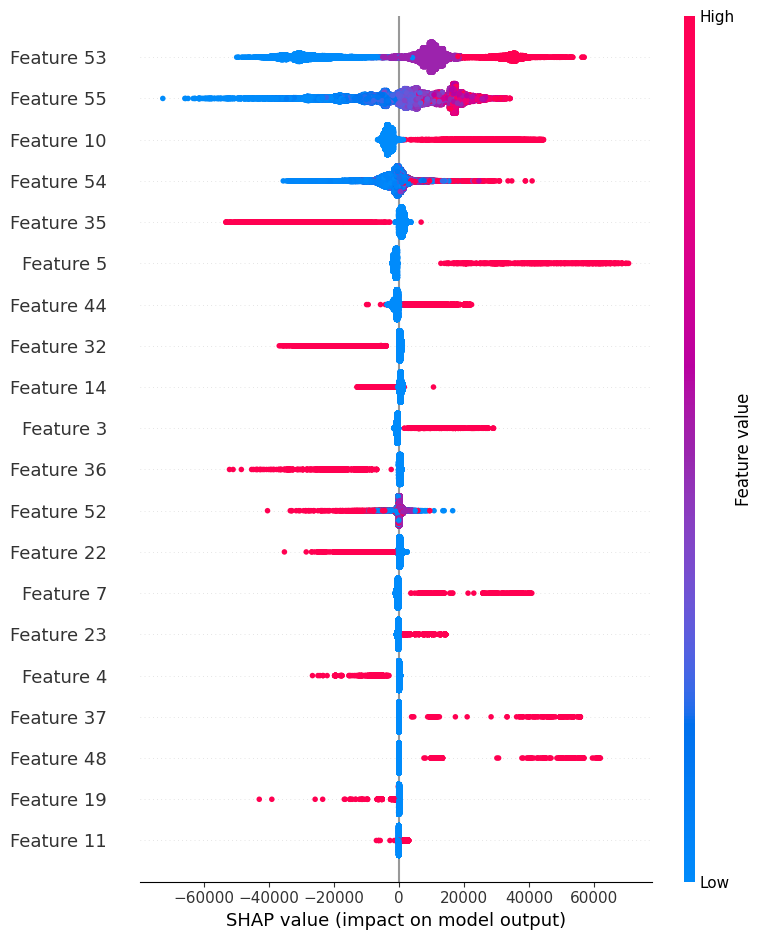

In [7]:
best_estimator = loaded_model.best_estimator_

# Separar el preprocesador del modelo final en el Pipeline
preprocessor = best_estimator.steps[:-1]
model = best_estimator.steps[-1][1]

# Preprocesar los datos de prueba
X_test_preprocessed = X_test.copy()
for transformer in preprocessor:
    X_test_preprocessed = transformer[1].transform(X_test_preprocessed)

# Convertir los datos preprocesados a matrices numpy densas
X_test_preprocessed = X_test_preprocessed.toarray() if hasattr(X_test_preprocessed, 'toarray') else X_test_preprocessed

# Crear un explainer SHAP basado en el modelo final
explainer = shap.Explainer(model, X_test_preprocessed)

# Calcular los valores SHAP
shap_values = explainer(X_test_preprocessed, check_additivity=False)

# Visualizar los valores SHAP (por ejemplo, un resumen de gráfico de dispersión)
shap.summary_plot(shap_values, X_test_preprocessed)